# Active Automata Learning: Angluin's L* algorithm
### Matt Earnshaw

Given the black box nature of many machine learning models, the increasing use of such models in everyday life, and associated legal constraints, "explainability" has become a key issue. If trust the public is to trust these models, it needs to understand how its decisions are made. Explainability is also an import input into the feasibility of creating visualizations to explain concepts. One approach to this problem is consideration of methods whose outputs are intrinsically explainable (when they are applied in the right context).

In my view these methods include: topological data analysis, decision trees, inductive logic programming, interactive theorem proving, and active automata learning.

Furthermore, in using machine learning as a lens to understand human intelligence and vice-versa, online or active learning methods will surely play a key role, since humans do not operate in batch mode!

Here we present a version of Angluin's L* algorithm for the active learning of deterministic finite automata (DFAs). Active automata learning is an ongoing research topic, and this algorithm has been generalized to the coalgebraic setting, a perspective unifying the learning of many different kinds of automata (Mealy machines, labelled transition systems, etc.)

# Generalities on L*

Active automata learning occurs within the framework of a **minimally adequate teacher**, a kind of oracle that can answer two kinds of queries from a learner, **membership** and **conjecture** queries. A **membership query** is a query as to whether a certain sequence of inputs (word) is accepted by the automaton to be learned. A **conjecture query** is a query as to whether a conjectured automaton is behaviourally equivalent to the one to be learned, returning a counterexample (which may be a negative counterexample) if not.

In [3]:
from abc import ABC, abstractmethod

class Teacher(ABC):
    """An interface for Minimally Adequate Teachers"""
    
    @abstractmethod
    def accepts(self, input):
        pass
    
    @abstractmethod
    def counterexample(self, conjecture):
        pass

The **L* algorithm** [[Angluin](https://dx.doi.org/10.1016/0890-5401(87)90052-6)] can efficiently learn a **deterministic finite automaton** (DFA) from a minimally adequate teacher. Initially known within grammatical inference and linguistic communities, it has more recently proven itself a powerful tool in verification and security (see figure below).

Note that membership queries would not themselves be sufficient to give an efficient learning algorithm for DFAs (consider a combination lock).

The algorithm builds a table of observations based on the response to membership queries. The rows correspond to (conjectural) states in the automaton, and columns to "experiments" (test inputs) performed on a given state. An entry in the table at (row, column) records the response to a query whether the automaton accepts the concatenation of the row and column labels. We also record table entries for "successors", represented by the bottom division of the table in the figure below.

Two rows that differ cannot correspond to the same conjectural state, as it means there is some input to those states that takes them to two different states.

![](images/ot.png) (image [source](dx.doi/10.1007/978-3-030-17601-3_2))


```python
class ObservationTable:
    def __init__(self, teacher: Teacher, alphabet: Tuple[str, ...]):
        """
        :param teacher: Implements `accepts` and `counterexample` methods
        :param alphabet: The alphabet of the target to be learned
        """
        self._alphabet = alphabet
        self._teacher = teacher
        # we start with just the row & column for the empty word
        self._cols = ('',)
        self._rows = [Row('', self._cols, (teacher.accepts(''),))]
        self._derivative_rows = []
        self._make_derivative_rows()

    @property
    def all_rows(self) -> List[Row]:
        return self._rows + self._derivative_rows

    def __repr__(self):
        row_data = [[row.label]+list(row.entries) for row in self.all_rows]
        return tabulate(row_data, headers=['X'] + list(self._cols))

    def __getitem__(self, key) -> Optional[Row]:
        try:
            return list(filter(lambda x: x.label == key, self.all_rows))[0]
        except IndexError:
            return None
```

We can construct an automaton from an observation table that is **closed**, meaning that for all successor rows (bottom part of table), we already have a row (state) in the top part corresponding to it: successors do not correspond to new states (quotiented by all experiment strings so far).

```python
def closed(self) -> Tuple[bool, Optional[Row]]:
    """Table is closed if for every derivative row, there is a row
    that has the same entries (i.e. derivatives are not new states).
    :return: (is closed?, non-matching derivative if not closed)
    """
    for row in self._derivative_rows:
        if row.entries not in [state.entries for state in self._rows]:
            return False, row
    return True, None

def make_closed(self) -> None:
    """To make a table closed, add the inconsistent derivative to top
    of table ("rows"), and make new derivatives."""
    is_closed, counterexample = self.closed()
    if not is_closed:
        self._rows.append(counterexample)
        self._make_derivative_rows()
```

In [125]:
import angluin
from teachers import DummyTeacher

# Table is initialized with empty string row and column
ot = angluin.ObservationTable(DummyTeacher(), alphabet=('a',))
ot['']['']

False

In [16]:
ot.closed() # ot.make_closed()

(True, None)

In order for the automaton constructed from a closed table to be consistent with the data in the table, the table must also satisfy **consistency**: every pair of states identical (under experiments) remain identical under all derivatives.

$OT[s] = OT[r] \implies \forall a \in A, OT[sa] = OT[ra]$, where $A$ is the alphabet.

To make an inconsistent table consistent, let $a$ be the witness of inconsistency ($OT[s] = OT[r]$ but $OT[sa] \neq OT[ra]$), and $e$ experiment at which the inconsistency occurs ($OT[sa][e] \neq OT[ra][e]$). Then adding $ae$ to the columns (experiments), distinguishes the rows.

![](images/consistent.png) Source: de la Higuera, Grammatical Inference

```python
def consistent(self) -> Tuple[bool, Optional[str]]:
    """A table is consistent if every pair of identical pair of rows remain
    identical under all derivatives.

    :return: (is consistent?, distinguishing letter if not consistent)
    """
    # group rows according to their entries
    matching_rows = groupby_unsorted([row for row in self._rows],
                                     key=lambda x: x.entries)
    for key, group in matching_rows:
        group = list(group)
        # get all pairs of matching rows and exclude the diagonal (a,a)
        pairs = itertools.product(group, group)
        pairs = list(filter(lambda x: x[0].label != x[1].label, pairs))
        for a in self._alphabet:
            for pair in pairs:
                # check if derivatives match
                for e in self._cols:
                    if (self[pair[0].label+a][e] != self[pair[1].label+a][e]):
                        return False, a+e
    return True, None

def make_consistent(self) -> None:
    """To make a table consistent, add the distinguishing suffix to cols
    and fill the column via membership queries."""
    is_consistent, counterexample = self.consistent()
    while not is_consistent:
        if counterexample not in self._cols:
            self._cols += (counterexample,)
```

In [13]:
ot.consistent() # ot.make_consistent()

(True, None)

If the conjecture made from a closed and consistent table is deemed by the learner not to be equivalent to the target, the learner provides a counterexample, which is added to the table along with all of its prefixes.

```python
def process_counterexample(self, label: str, conjecture: DFA) -> bool:
    """Add counterexample and its prefixes to rows, and add derivative
    rows"""
    if conjecture.accepts(label) == self._teacher.accepts(label):
        print("False counter example, already both reject or both accept.")
        return False
    new_row = Row(label, self._cols, tuple(self._teacher.accepts(label+c)
                                           for c in self._cols))
    self._rows.append(new_row)
    # add all the prefixes too
    for i in range(len(label)):
        prefix = label[:i]
        if prefix not in list(map(lambda x: x.label, self._rows)):
            new_row = Row(prefix, self._cols, tuple(self._teacher.accepts(prefix+col)
                                        for col in self._cols))
            self._rows.append(new_row)
    self._make_derivative_rows()
    return True
```

The process repeats until no counterexample can be given.

# An interactive example

In [ ]:
from teachers import DFA, render_DFA

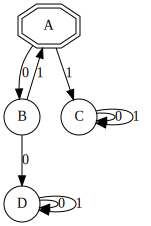

In [134]:
# make a DFA that accepts (01)*
transition_table = {
    "A": {'0' : "B", '1': "C"},
    "B": {'0' : "D", '1': "A"},
    "C": {'0' : "C", '1': "C"},
    "D": {'0' : "D", '1': "D"},
    }
dfa1 = DFA(transition_table, initial_state="A", accepting_states=["A"])
render_DFA(dfa1)

In [ ]:
learned_dfa = angluin.Lstar_interactive(dfa1, ('0','1'))

# Probing black boxes with L*

To illustrate some applications of the L* algorithm, some simple RNNs were trained on data generated by regular expressions (which are equivalent to DFAs). Some of these models were made deliberately sloppy by overfitting, lack of validation etc. to mimic the kinds behaviour that might be exhibited by a concrete system that has been constructued ad-hoc or insufficiently tested.

In this case, the black box cannot answer conjecture queries exactly, because it is not a DFA. So we use sampling in order to produce counterexamples, and if the sampling is extensive then when no counterexample can be found, we have equivalence with a high probability (cf. Angluin's paper).

N.B. I am not proposing that L* is necessarily a good tool for explaining neural networks.

In [187]:
 data_info = {}

In [214]:
import re
import random

# Generate some data from regular expressions for training an RNN
regexes = [r"a+", ".a(bc)*", "(ab)+","b.*"]

# save some information about each dataset
# here we want to match a+ over strings with chars drawn from a,b
data_info["a+"] = {}
data_info["a+"]['alphabet'] = ('a','b')

# here we want to match b.* over strings with chars drawn from a,b,c
data_info["b.*"] = {}
data_info["b.*"]['alphabet'] = ('a','b','c')

n_samples = 20000
max_sample_length = 10

for regex in regexes:
    if not data_info.get(regex):
        data_info[regex] = {}
   
    try:
        alphabet = data_info[regex]['alphabet']
    except KeyError:
        alphabet = tuple(filter(lambda x: x.isalnum(), regex))
        data_info[regex]['alphabet'] = alphabet

    pattern = re.compile(regex)

    with open("grammars/grammar_{}".format(regex), 'w') as f:
        for i in range(n_samples):
            l = random.randint(0, max_sample_length)
            s = ''.join([random.choice(alphabet) for i in range(l)])
            print(s, True if re.fullmatch(pattern, s) else False, file=f, sep=',')

In [197]:
import keras
import pandas as pd
import numpy as np
from keras import preprocessing
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.preprocessing import LabelEncoder

In [198]:
pd.read_csv("grammars/grammar_a+".format(regex), header=None)

,0,1
0,aab,False
1,ab,False
2,aaa,True
3,aaabaaaba,False
4,aa,True
...,...,...
19995,NaN,False
19996,aba,False
19997,abbabb,False
19998,ababaaaab,False


In [199]:
def create_model():
    model = Sequential()  # linear stack of layers
    model.add(LSTM(10, activation='relu', input_shape=(None,1)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
    return model

In [220]:
model_path = "models/{}_model.json"
weights_path = "models/{}_weights.h5"

regexes = ["b.*"]

# Preprocess data
for regex in regexes:
    df = pd.read_csv("grammars/grammar_{}".format(regex), header=None)
    
    # split dataframe, first column X, second column Y
    Y = df.loc[:,1]
    # NaN means empty string
    X = df.loc[:,0].replace(np.nan, '', regex=True)
    
    # tokenize strings at character level and pad
    tok = preprocessing.text.Tokenizer(char_level=True)
    tok.fit_on_texts(X)
    processed_X = preprocessing.sequence.pad_sequences(tok.texts_to_sequences(X), padding="post")
    # reshape: batch size, timesteps, input dim
    processed_X = processed_X.reshape(len(X), max_sample_length, 1)
    
    # label encode our True/False column
    encoder = LabelEncoder()
    encoder.fit(Y)
    processed_Y = encoder.transform(Y)
    
    # keep map of how tokenizer has replaced letters with numbers
    data_info[regex]['mapping'] = {v: k for k, v in tok.index_word.items()}
    
    model = create_model()
    fitted = model.fit(processed_X, processed_Y, epochs=10, batch_size=1, validation_split=0.05, verbose=1)
    
    model.save(model_path.format(regex))
    model.save_weights(weights_path.format(regex))

Train on 19000 samples, validate on 1000 samples
Epoch 1/10
19000/19000 [==============================] - 74s 4ms/step - loss: 0.1053 - accuracy: 0.8585 - val_loss: 1.3139e-05 - val_accuracy: 1.0000
Epoch 2/10
19000/19000 [==============================] - 64s 3ms/step - loss: 9.8710e-07 - accuracy: 1.0000 - val_loss: 6.8716e-11 - val_accuracy: 1.0000
Epoch 3/10
19000/19000 [==============================] - 82s 4ms/step - loss: 8.9035e-12 - accuracy: 1.0000 - val_loss: 2.8153e-13 - val_accuracy: 1.0000
Epoch 4/10
19000/19000 [==============================] - 85s 4ms/step - loss: 1.9182e-13 - accuracy: 1.0000 - val_loss: 1.1441e-13 - val_accuracy: 1.0000
Epoch 5/10
19000/19000 [==============================] - 70s 4ms/step - loss: 9.6030e-14 - accuracy: 1.0000 - val_loss: 6.9102e-14 - val_accuracy: 1.0000
Epoch 6/10
19000/19000 [==============================] - 62s 3ms/step - loss: 6.3189e-14 - accuracy: 1.0000 - val_loss: 4.6883e-14 - val_accuracy: 1.0000
Epoch 7/10
19000/19000 [=

In [221]:
from teachers import RNN, render_DFA

In [206]:
regex = "a+"
rnn = teachers.RNN(model_path.format(regex), weights_path.format(regex), data_info[regex]['mapping'])
rnn.accepts("aab")

True

This should just accept strings that contain one or more "a"s. Let's extract the DFA using L*:

Closing...
Processing counterexample:  bbbaaa
Making consistent...
Processing counterexample:  aaab
Making consistent...
Closing...
Closing...
Closing...
Processing counterexample:  aaaaaaaba
Making consistent...
Closing...


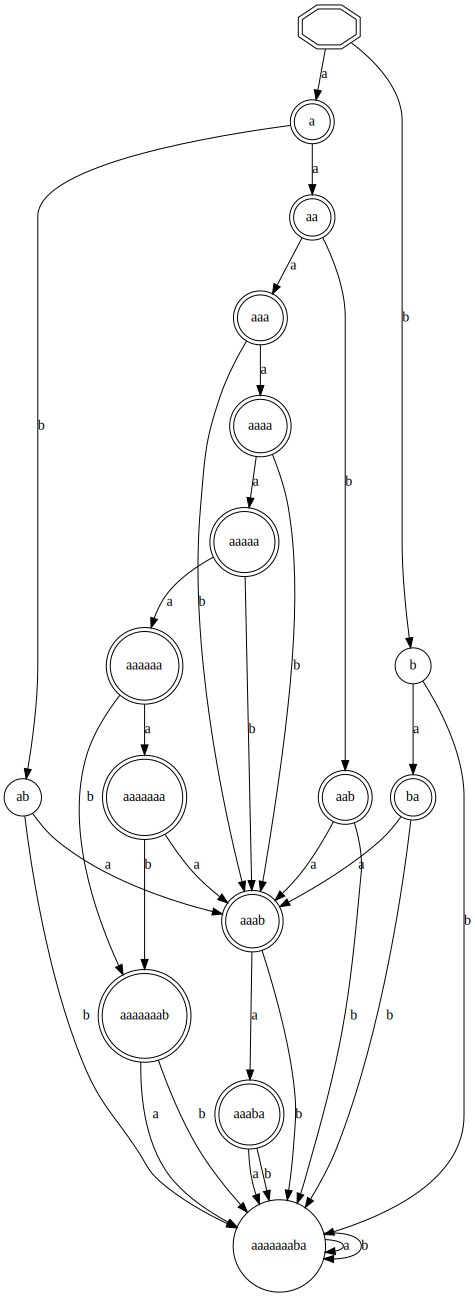

In [209]:
dfa = angluin.Lstar(rnn, data_info[regex]['alphabet'], angluin.fuzzer)

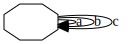

In [212]:
regex = ".a(bc)*"
rnn = teachers.RNN(model_path.format(regex), weights_path.format(regex), data_info[regex]['mapping'])

dfa = angluin.Lstar(rnn, data_info[regex]['alphabet'], angluin.fuzzer)

In [ ]:
regex = "b.*"
rnn = teachers.RNN(model_path.format(regex), weights_path.format(regex), data_info[regex]['mapping'])
dfa = angluin.Lstar(rnn, data_info[regex]['alphabet'], angluin.fuzzer)

Processing counterexample:  caccacabb
Making consistent...
Processing counterexample:  aaabcaacc
Making consistent...
Processing counterexample:  accabbbb
Making consistent...
Closing...
Closing...
Processing counterexample:  cacaacbab
Making consistent...
Closing...
Closing...
Processing counterexample:  caabacbba
Making consistent...
Closing...
Closing...
Closing...
Closing...
Closing...
Processing counterexample:  accbcabb
Making consistent...
Closing...
Closing...
Processing counterexample:  ccaaccbcb
Making consistent...
Closing...
Closing...
Processing counterexample:  caaccbacb
Making consistent...
Closing...
Closing...
Closing...
Closing...
Closing...
Processing counterexample:  cabcbbccc
Making consistent...
Closing...
Closing...
Closing...
Closing...
Closing...
Closing...
Closing...
Closing...
Closing...
Closing...
Closing...
Closing...
Processing counterexample:  caacbccba
Making consistent...
Closing...
Closing...
Closing...
Processing counterexample:  caccaaaab
Making cons

![A](images/tls.png "caption")Source: de Ruiter et al 2015, [Protocol State Fuzzing of TLS Implementations](https://www.usenix.org/system/files/conference/usenixsecurity15/sec15-paper-de-ruiter.pdf)

# Conclusions

- Angluin's L* algorithm can learn DFAs via an active style of learning, using queries and counterexamples
- DFAs can be learned exactly if counterexample queries can be answered exactly, or probabilistically using sampling to fuzz for counterexamples
- The algorithm has proven applications in verification and grammatical inference
- The output of the algorithm is a visualizable, understandable, diagrammatic form that summarizes the behaviour of a system
- Active automata learning is a rich field and the theory is now understood at a level of generality applies to many kinds of target system